## Part 00: TF-IDF + NMF

In [1]:
import gc
from sklearn.decomposition import NMF

gc.enable()

In [2]:
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # Get a sorted list of the objects and their sizes
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [3]:
import pickle

with open("Data/df.pkl", 'rb') as picklefile:
    df = pickle.load(picklefile)

Let's do our analysis on stemmed words so that same topic is not split (e.g. "word" and "words" should belong to the same topic):

In [4]:
# import nltk
# from textblob import TextBlob
# stemmer = nltk.stem.porter.PorterStemmer()

# def stem_getter(text):
#     return " ".join([stemmer.stem(word) for word in TextBlob(text).words])

# df.raw_text = df.raw_text.map(stem_getter)

This time around, let's remove words in all caps: they are used to indicate character lines. Using them will just create topics identifying major characters of a show/movie which is not helpful. Let's also remove non-letter characters along the way:

In [5]:
import re

In [6]:
def cap_remover(text):
    text = re.sub(r'[A-Z]+(?![a-z])', '', text)
    text = re.sub(r'[\d]+', '', text)
    text = re.sub(r' +', ' ', text)
    return re.sub(r"[^\w' ]", '', text)

In [7]:
df.raw_text = df.raw_text.map(cap_remover)

In [8]:
# def stopword_remover(text):
#     return " ".join([word for word in text.lower().split() if word not in stoplist])

In [9]:
# df.raw_text = df.raw_text.map(stopword_remover)

In [10]:
# df.raw_text[0]

In [11]:
# df.head()

In [12]:
%pylab inline
import numpy 
import matplotlib.pyplot as plt
import sklearn
# Import all of the scikit learn stuff
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import Normalizer
from sklearn import metrics
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [13]:
docs = df.raw_text

I have also used a large list of keywords from [here](http://www.ranks.nl/stopwords) and supplemented it with Star Trek specific terms discovered in the initial LDA model so that they are not used in topic analysis:

In [14]:
with open('Data/stopwords_wpropers.txt') as f:
     content = (f.read()).split()#f.readlines()
# for i in range(len(content)):
#     content[i] = content[i].replace("\n", "").lower()
stoplist = sorted(list(set(content)))
# texts = [" ".join([word for word in cluster_dict[i].lower().split() if word not in stoplist])
#          for i in cluster_dict.keys()]

In [15]:
vectorizer = TfidfVectorizer(stop_words = stoplist, ngram_range=(1, 3))
dtm = vectorizer.fit_transform(docs) 
# pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names()).head(10)

In [16]:
# vectorizer.get_feature_names()

The optimal number of topics to explore is 15 (a search I performed on the side until topics started to make sense):

In [17]:
num_topics = 15
nmf_model = NMF(num_topics)

dtm_nmf = nmf_model.fit_transform(dtm)

# use NMF to attempt Topic Modeling
words = vectorizer.get_feature_names()

# get num_topic_words top topic words:
num_topic_words = 30

# iterate through our eigenvectors
print("The topics for {} topic NMF are:".format(num_topics))
for r in nmf_model.components_:
    # sort values associated with each dimension 
    a=sorted([(v,i) for i,v in enumerate(r)])[-num_topic_words:]
    # map back to words
    print([words[i[1]] for i in a])
print()

The topics for 15 topic NMF are:
['room', 'doctor', 'reacts', 'promenade', 'long', 'sees', 'hand', 'suddenly', 'major', 'smile', 'head', 'people', 'table', 'well', 'eyes', 'good', 'man', 'station', 'face', 'nods', 'takes', 'moves', 'bar', 'door', 'moment', 'turns', 'smiles', 'time', 'going', 'beat']
['hall', 'medical', 'people', 'commander', 'warp', 'course', 'mess hall', 'ensign', 'astrometrics lab', 'holographic', 'shields', 'good', 'help', 'lieutenant', 'hologram', 'mister', 'lab', 'astrometrics', 'computer', 'crew', 'engineering', 'time', 'well', 'going', 'holodeck', 'sickbay', 'ship', 'doctor', 'bridge', 'programme']
['admiral', 'head', 'tricorder', 'panel', 'works', 'genesis', 'bridge', 'gambit', 'takes', 'smiles', 'eyes', 'computer', 'viewer', 'suddenly', 'door', 'warp', 'face', 'time', 'room', 'commander', 'nods', 'moment', 'reacts', 'turns', 'moves', 'ship', 'console', 'sir', 'continuing', 'beat']
['bay', 'crew', 'species', 'plating', 'help', 'pod', 'high command', 'well', 'ro

Applying some domain knowledge, the 15 topics are: 
1. Action: ['room', 'doctor', 'reacts', 'promenade', 'long', 'sees', 'hand', 'suddenly', 'major', 'smile', 'head', 'people', 'table', 'well', 'eyes', 'good', 'man', 'station', 'face', 'nods', 'takes', 'moves', 'bar', 'door', 'moment', 'turns', 'smiles', 'time', 'going', 'beat']
1. Daily Life on a Spaceship: ['hall', 'medical', 'people', 'commander', 'warp', 'course', 'mess hall', 'ensign', 'astrometrics lab', 'holographic', 'shields', 'good', 'help', 'lieutenant', 'hologram', 'mister', 'lab', 'astrometrics', 'computer', 'crew', 'engineering', 'time', 'well', 'going', 'holodeck', 'sickbay', 'ship', 'doctor', 'bridge', 'programme']
1. Space Battle Tactics: ['admiral', 'head', 'tricorder', 'panel', 'works', 'genesis', 'bridge', 'gambit', 'takes', 'smiles', 'eyes', 'computer', 'viewer', 'suddenly', 'door', 'warp', 'face', 'time', 'room', 'commander', 'nods', 'moment', 'reacts', 'turns', 'moves', 'ship', 'console', 'sir', 'continuing', 'beat']
1. Space Exploration: ['bay', 'crew', 'species', 'plating', 'help', 'pod', 'high command', 'well', 'room', 'commander', 'launch bay', 'launch', 'engineering', 'find', 'command', 'earth', 'three', 'hull', 'people', 'ships', 'weapons', 'weapon', 'warp', 'viewscreen', 'time', 'shuttlepod', 'sir', 'going', 'bridge', 'ship']
1. Systematic Oppression: ['captive pursuit hunter', 'lead alien', 'pursuit hunter', 'hunters', 'helmet', 'quadrant', 'nodes', 'combadge', 'rules', 'aliens', 'optical flash', 'uhhuh', 'ship', 'security', 'die honor', 'moves', 'crossbow', 'barkeep', 'captive pursuit captive', 'pursuit captive', 'pursuit captive pursuit', 'wormhole', 'reacts', 'hunt', 'alien', 'beat', 'hunter', 'pursuit', 'captive', 'captive pursuit']
1. Cross-Cultural Interaction: ['vortex', 'gland', 'ointment', 'weapon', 'runs hands', 'fair price', 'bridge ahead', 'interested find', 'liquid form', 'met station', 'woman white', 'market', 'agree fair', 'agree fair price', 'confident agree', 'confident agree fair', 'market chemist', 'humans', 'species', 'liquid', 'synthesise', 'shop', 'barge', 'bioweapon', 'chemist shop', 'quarters', 'rat', 'barge twelve', 'brig', 'chemist']
1. Land Exploration: ['party', 'landing party', 'commodore', 'log', 'earth', 'orbit', 'sickbay', 'creature', 'beam', 'yeoman', 'course', 'men', 'phaser', 'transporter room', 'surface', 'time', 'aye', 'power', 'room', 'lieutenant', 'planet surface', 'transporter', 'man', 'well', 'ship', 'doctor', 'planet', 'bridge', 'sir', 'mister']
1. Future Engineering: ['warp', 'chef', 'launch bay', 'echo', 'phase', 'port', 'eat', 'well', 'spacedock', 'ship', 'relays', 'armoury officer', 'pineapple', 'birthday', 'dinner', 'online', 'likes eat', 'green ship', 'ship armoury', 'cannon', 'favourite', 'recoil', 'metres', 'favourite food', 'amplifier', 'sir', 'bridge', 'cannons', 'monitor', 'armoury']
1. Logic vs. Tradition: ['knife', 'bird', 'continuing', 'prey', 'moment', 'house', 'console', 'high council', 'bird prey', 'son', 'federation', 'moves', 'family', 'father', 'ship', 'brother', 'fleet', 'ships', 'reunion', 'sins', 'honor', 'sins father', 'warrior', 'empire', 'sword', 'sons', 'toral', 'council', 'beat', 'redemption']
1. Individualism vs. Collectivism: ['central plexus', 'shields', 'node', 'sickbay', 'raven', 'maturation', 'species', 'time', 'vinculum', 'technology', 'assimilation', 'bay', 'irrelevant', 'cargo', 'assimilate', 'chamber', 'sphere', 'vessel', 'bridge', 'cargo bay', 'queen', 'transwarp', 'queen chamber', 'nanoprobes', 'assimilated', 'drone', 'drones', 'unimatrix', 'cube', 'collective']
1. Against All Odds: ['cell', 'number', 'life', 'planet surface', 'minds', 'colt', 'mind', 'survivors encampment', 'ship', 'primitive', 'screen', 'flash', 'offspring', 'commodore', 'laser', 'zoo', 'read thoughts', 'keeper', 'planet', 'illusions', 'specimens', 'read', 'sir', 'magistrate', 'thoughts', 'survivors', 'specimen', 'hearing room', 'cage', 'illusion']
1. Authoritarianism: ['eyes', 'people', 'turns', 'oc', 'mister', 'warbird', 'soup', 'peace', 'depot', 'surplus', 'moves', 'acknowledges', 'senator', 'commander', 'reacts', 'ship', 'senate', 'ships', 'sir', 'unification unification', 'federation', 'defector', 'zone', 'proconsul', 'reunification', 'ambassador', 'beat', 'neutral', 'neutral zone', 'unification']
1. Religion: ['prophecy', 'image', 'tablet', 'hands', 'alien', 'strange', 'major', 'smiles', 'moves', 'going', 'reacts', 'turns', 'obelisk', 'federation', 'shadows', 'face', 'admiral', 'temple', 'tears', 'collaborator', 'station', 'destiny', 'orb', 'rapture', 'beat', 'wormhole', 'accession', 'reckoning', 'prophets', 'emissary']
1. Resisting Tyranny: ['cloaking', 'shattered', 'slave', 'cloaking device', 'regent', 'smiles', 'phaser', 'ore processing center', 'crossover', 'processing center', 'rebel', 'founders', 'processing', 'rebels', 'ship', 'ore', 'emperor', 'workers', 'overseer', 'ore processing', 'mirror', 'die', 'shattered mirror', 'rebellion', 'beat', 'cast', 'intendant', 'alliance', 'glass', 'die cast']
1. Reimagining History: ['le coeur de', 'observatory rain', 'weapons', 'history', 'sainte', 'sainte claire', 'earth', 'claire', 'ship', 'holodeck', 'german', 'continuum', 'observatory', 'relativity', 'germans', 'weapons facility', 'rain', 'nazi weapons', 'nazi weapons facility', 'bridge', 'future', 'going', 'arrow', 'street', 'century', 'time arrow', 'nazi', 'time', 'timeship', 'temporal']

Saving progress jut in case:

In [18]:
with open("Data/nmf_model.pkl", 'wb') as picklefile:
    pickle.dump(nmf_model, picklefile)
with open("Data/dtm_nmf.pkl", 'wb') as picklefile:
    pickle.dump(dtm_nmf, picklefile)

In [3]:
with open("Data/nmf_model.pkl", 'rb') as picklefile:
    nmf_model = pickle.load(picklefile)
with open("Data/dtm_nmf.pkl", 'rb') as picklefile:
    dtm_nmf = pickle.load(picklefile)

15 topics with ~2,700,000 ngrams:

In [19]:
nmf_model.components_.shape

(15, 2720441)

So we have 678 documents and the matrix has ~2,700,000 ngrams associated with it.

In [20]:
dtm.shape

(678, 2720441)

678 Star Trek scripts with 15 topics distributed per each episode.

In [21]:
dtm_nmf.shape

(678, 15)

Now I would like to add topic distributions on a yearly basis:

In [22]:
topic_dist = df.join(pd.DataFrame(dtm_nmf), how='outer').groupby(df.airdate.dt.year).sum()
topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
airdate,,,,,,,,,,,,,,,
1966,0.051246,0.068491,0.016113,0.017591,0.000360,0.002770,1.741919,0.028787,0.001723,0.014300,1.801039,0.071301,0.000000,0.000927,0.019090
1967,0.109157,0.062149,0.007103,0.046064,0.012826,0.024090,4.110481,0.015205,0.104377,0.019264,0.020026,0.041794,0.024829,0.036703,0.127834
1968,0.094248,0.055318,0.015881,0.026897,0.000293,0.013729,1.106294,0.009209,0.004609,0.023061,0.021826,0.006360,0.000284,0.027091,0.331739
1979,0.000000,0.000000,0.247150,0.002697,0.000000,0.000000,0.041015,0.001345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1982,0.000000,0.000000,0.176275,0.013457,0.000000,0.000000,0.034004,0.000246,0.000000,0.000000,0.000199,0.000000,0.000862,0.000000,0.000000


Let's normalize:

In [23]:
topic_dist = topic_dist.apply(lambda x: x/np.sum(x), axis=1)
topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
airdate,,,,,,,,,,,,,,,
1966,0.013361,0.017856,0.004201,0.004586,0.000094,0.000722,0.454138,0.007505,0.000449,0.003728,0.469552,0.018589,0.000000,0.000242,0.004977
1967,0.022923,0.013051,0.001492,0.009674,0.002693,0.005059,0.863202,0.003193,0.021919,0.004045,0.004205,0.008777,0.005214,0.007708,0.026845
1968,0.054264,0.031850,0.009143,0.015486,0.000169,0.007904,0.636959,0.005302,0.002653,0.013277,0.012566,0.003662,0.000163,0.015598,0.191002
1979,0.000000,0.000000,0.845803,0.009231,0.000000,0.000000,0.140363,0.004603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1982,0.000000,0.000000,0.783298,0.059798,0.000000,0.000000,0.151099,0.001091,0.000000,0.000000,0.000885,0.000000,0.003829,0.000000,0.000000


And fill the gaps in years:

In [24]:
index = list(range(1966, 2006))
var = np.ones(2006-1966)
dummy_df = pd.DataFrame(data=var, index=index, columns=['var'])
topic_dist = topic_dist.join(dummy_df, how='outer').drop('var', axis=1).fillna(0)

In [25]:
topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1966,0.013361,0.017856,0.004201,0.004586,0.000094,0.000722,0.454138,0.007505,0.000449,0.003728,0.469552,0.018589,0.000000,0.000242,0.004977
1967,0.022923,0.013051,0.001492,0.009674,0.002693,0.005059,0.863202,0.003193,0.021919,0.004045,0.004205,0.008777,0.005214,0.007708,0.026845
1968,0.054264,0.031850,0.009143,0.015486,0.000169,0.007904,0.636959,0.005302,0.002653,0.013277,0.012566,0.003662,0.000163,0.015598,0.191002
1969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
columns = [
"Action",
"Daily Life on a Spaceship",
"Space Battle Tactics",
"Space Exploration",
"Systematic Oppression",
"Cross-Cultural Interaction",
"Land Exploration",
"Future Engineering",
"Logic vs. Tradition",
"Individualism vs. Collectivism",
"Against All Odds",
"Authoritarianism",
"Religion",
"Resisting Tyranny",
"Reimagining History"
]
topic_dist.columns = columns
topic_dist.head()

,Action,Daily Life on a Spaceship,Space Battle Tactics,Space Exploration,Systematic Oppression,Cross-Cultural Interaction,Land Exploration,Future Engineering,Logic vs. Tradition,Individualism vs. Collectivism,Against All Odds,Authoritarianism,Religion,Resisting Tyranny,Reimagining History
1966,0.013361,0.017856,0.004201,0.004586,0.000094,0.000722,0.454138,0.007505,0.000449,0.003728,0.469552,0.018589,0.000000,0.000242,0.004977
1967,0.022923,0.013051,0.001492,0.009674,0.002693,0.005059,0.863202,0.003193,0.021919,0.004045,0.004205,0.008777,0.005214,0.007708,0.026845
1968,0.054264,0.031850,0.009143,0.015486,0.000169,0.007904,0.636959,0.005302,0.002653,0.013277,0.012566,0.003662,0.000163,0.015598,0.191002
1969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Time to plot the results!

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [28]:
# sns.choose_colorbrewer_palette('sequential')

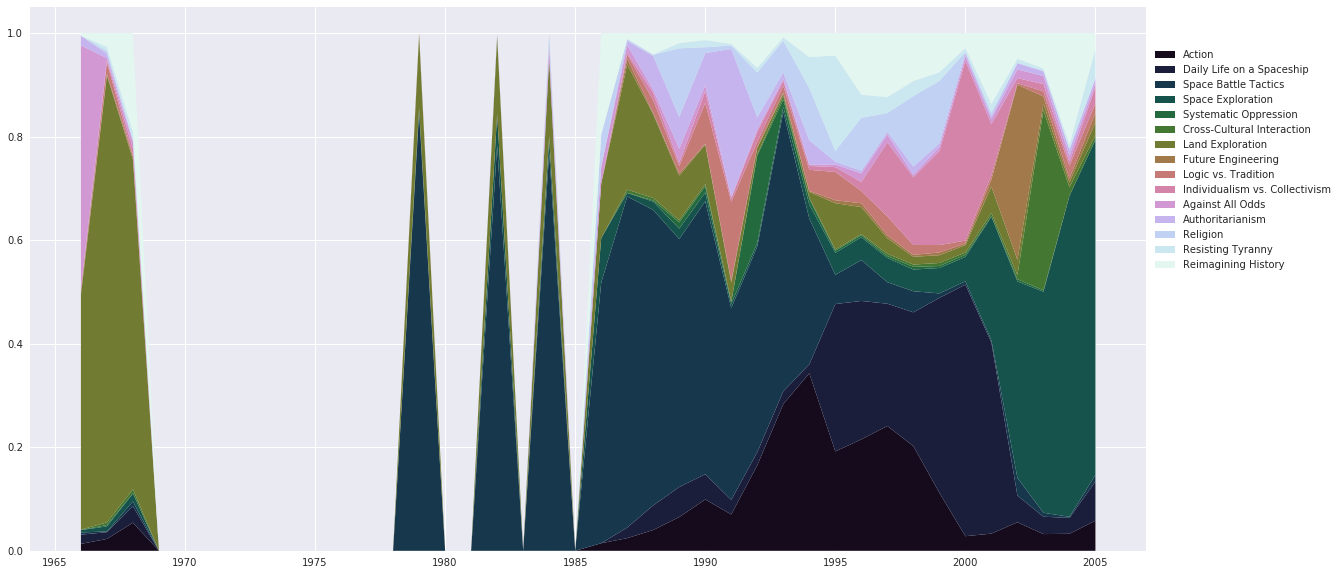

In [58]:
# sns.set_palette("husl")
colors = sns.color_palette("cubehelix", 15)
#sns.diverging_palette(145, 280, s=85, l=25, n=15)
#sns.diverging_palette(255, 133, l=60, n=15, center="dark")
#sns.color_palette(palette=None, n_colors=15, desat=None)

y = np.transpose(np.array(topic_dist))
x = np.array(topic_dist.index)
fig, ax = plt.subplots(figsize=(20,10))
ax.stackplot(x, y, labels=np.array(topic_dist.columns), colors=colors) 
ax.legend(loc='lower left',bbox_to_anchor=(1,0.5))
plt.show()

Let's makes some word clouds:

In [30]:
nmf_model.components_.shape

(15, 2720441)

In [31]:
len(vectorizer.get_feature_names())

2720441

In [33]:
word_list = vectorizer.get_feature_names()
word_clouds = list()
for topic in range(topic_dist.shape[1]):
    word_clouds.append(dict(zip(word_list, nmf_model.components_[topic])))

In [37]:
from wordcloud import WordCloud
#Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
#See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py

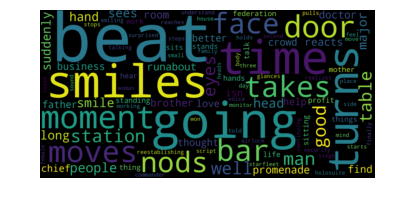

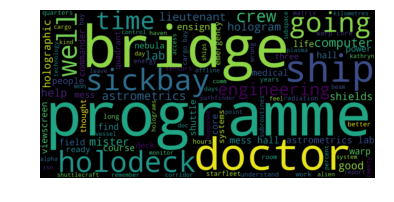

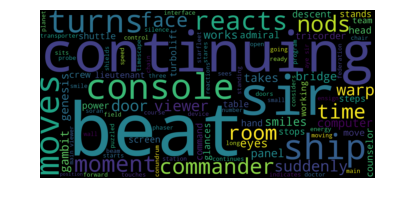

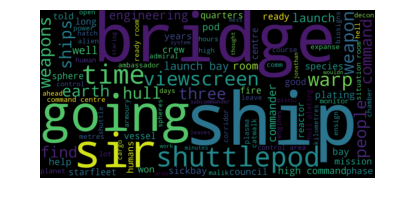

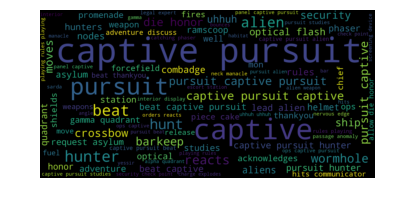

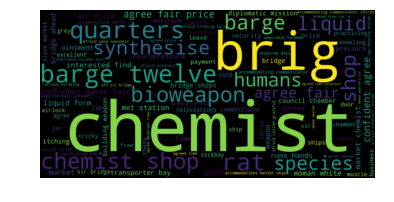

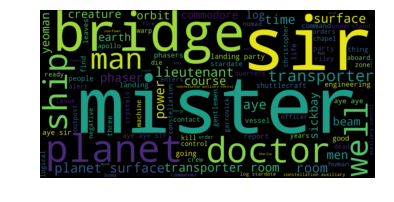

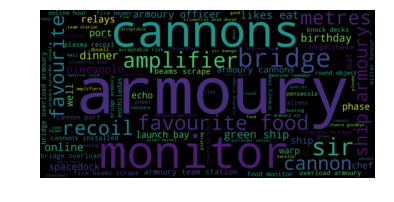

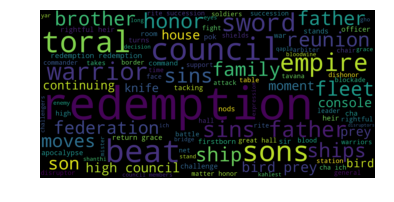

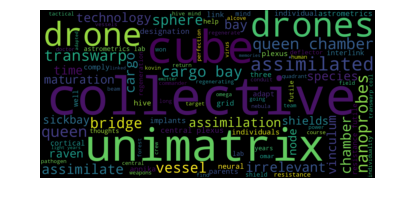

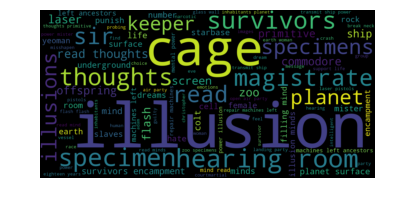

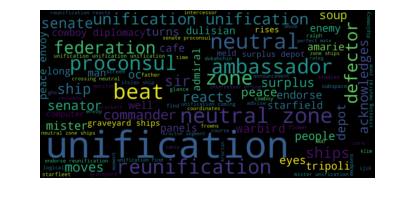

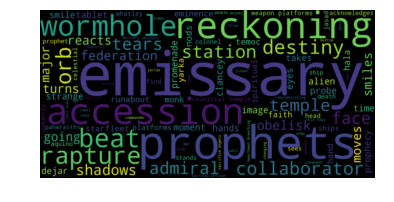

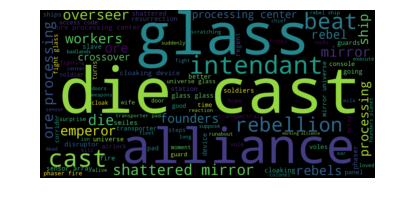

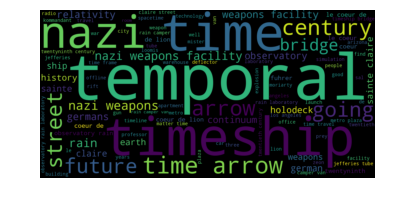

In [38]:
for word_cloud in word_clouds:
    wordcloud = WordCloud(width=2000,height=1000,normalize_plurals=True).generate_from_frequencies(word_cloud)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Now I would like to make a cool chart like [this](https://www.visualcinnamon.com/2015/10/different-look-d3-radar-chart.html):

In [67]:
x.shape

(40,)

In [64]:
y.shape

(15, 40)

In [70]:
all_data = list()
for topic in range(y.shape[0]):
    data_per_topic = list()
    yr = 0
    for year in x:
        data_per_topic.append({"axis":year, "value": y[topic,yr]})
        yr +=1
    all_data.append(data_per_topic)

In [76]:
all_data

[[{'axis': 1966, 'value': 0.013360519996393361},
  {'axis': 1967, 'value': 0.022922977710006797},
  {'axis': 1968, 'value': 0.054263991526176412},
  {'axis': 1969, 'value': 0.0},
  {'axis': 1970, 'value': 0.0},
  {'axis': 1971, 'value': 0.0},
  {'axis': 1972, 'value': 0.0},
  {'axis': 1973, 'value': 0.0},
  {'axis': 1974, 'value': 0.0},
  {'axis': 1975, 'value': 0.0},
  {'axis': 1976, 'value': 0.0},
  {'axis': 1977, 'value': 0.0},
  {'axis': 1978, 'value': 0.0},
  {'axis': 1979, 'value': 0.0},
  {'axis': 1980, 'value': 0.0},
  {'axis': 1981, 'value': 0.0},
  {'axis': 1982, 'value': 0.0},
  {'axis': 1983, 'value': 0.0},
  {'axis': 1984, 'value': 1.8890815868797963e-05},
  {'axis': 1985, 'value': 0.0},
  {'axis': 1986, 'value': 0.014598551202087624},
  {'axis': 1987, 'value': 0.024448106077199095},
  {'axis': 1988, 'value': 0.040184189785300278},
  {'axis': 1989, 'value': 0.065206922909253881},
  {'axis': 1990, 'value': 0.099139382875152254},
  {'axis': 1991, 'value': 0.07024754855555229